# Create a ball and stick neurons and save it to swc

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import pandas as pd
import numpy as np
import trimesh
from matplotlib import pyplot as plt
from collections import Counter

import skeliner as sk

In [2]:
def make_ball_and_stick_neuron(
    n_sticks=2,
    angles_deg=None,
    length=90,
    n_segments=8,
    soma_radius=10,
    stick_radius_profile=(2, 1),
    n_varicosities=0,
    varicosity_scale=1.5,
    seed=None
):
    """
    Create a ball-and-stick neuron model with optional varicosities.

    Parameters
    ----------
    n_sticks : int
        Number of dendritic sticks to attach to the soma.
    angles_deg : list of float, optional
        Angles (in degrees) for each stick in XY plane.
        If None, evenly spaced around soma.
    length : float
        Total length of each stick.
    n_segments : int
        Number of segments per stick.
    soma_radius : float
        Radius of the soma sphere.
    stick_radius_profile : tuple(float, float)
        (start_radius, end_radius) along each stick.
    n_varicosities : int
        Total number of varicosities (radius-enlarged nodes).
    varicosity_scale : float
        Factor by which the radius is multiplied at varicosity nodes.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    nodes : pd.DataFrame
        Columns: id, ntype, x, y, z, r, parent
    """
    if seed is not None:
        np.random.seed(seed)

    if angles_deg is None:
        angles_deg = np.linspace(0, 360, n_sticks, endpoint=False)
    elif len(angles_deg) != n_sticks:
        raise ValueError("Length of angles_deg must match n_sticks")

    nodes = []
    node_id = 1

    # Soma
    nodes.append(dict(
        id=node_id,
        ntype=1,
        x=0, y=0, z=0,
        r=soma_radius,
        parent=-1
    ))
    soma_id = node_id
    node_id += 1

    # Keep track of dendritic node indices for varicosities
    dendritic_ids = []

    # Build sticks
    for angle in angles_deg:
        rad = np.deg2rad(angle)
        x_dir, y_dir = np.cos(rad), np.sin(rad)

        # Make offset such that first segment starts at soma surface, take angle into account
        offset_x = x_dir * soma_radius
        offset_y = y_dir * soma_radius

        xs = np.linspace(0, length * x_dir, n_segments + 1)[1:] + offset_x
        ys = np.linspace(0, length * y_dir, n_segments + 1)[1:] + offset_y
        rs = np.linspace(stick_radius_profile[0], stick_radius_profile[1], n_segments + 1)[1:]

        parent = soma_id
        for xi, yi, ri in zip(xs, ys, rs):
            nodes.append(dict(
                id=node_id,
                ntype=3,
                x=xi, y=yi, z=0,
                r=ri,
                parent=parent
            ))
            dendritic_ids.append(node_id)
            parent = node_id
            node_id += 1

    df = pd.DataFrame(nodes)

    # Apply varicosities
    if n_varicosities > 0 and len(dendritic_ids) > 0:
        n_varicosities = min(n_varicosities, len(dendritic_ids))
        varico_nodes = np.random.choice(dendritic_ids, n_varicosities, replace=False)
        df.loc[df["id"].isin(varico_nodes), "r"] *= varicosity_scale

    return df


In [3]:
neuron = make_ball_and_stick_neuron(
    n_sticks=2,
    angles_deg=[0, 70],
    length=90,
    n_segments=50,
    stick_radius_profile=(2, 1),
    soma_radius=10,
    n_varicosities=5,
    varicosity_scale=3,
    seed=80
)

neuron_path = "data/ball_and_stick_neuron_v1.swc"
display(neuron)
neuron.to_csv(neuron_path, index=False, header=False, sep=' ')

,id,ntype,x,y,z,r,parent
0,1,1,0.000000,0.000000,0,10.00,-1
1,2,3,11.800000,0.000000,0,1.98,1
2,3,3,13.600000,0.000000,0,1.96,2
3,4,3,15.400000,0.000000,0,1.94,3
4,5,3,17.200000,0.000000,0,1.92,4
...,...,...,...,...,...,...,...
96,97,3,31.739469,87.203475,0,3.24,96
97,98,3,32.355106,88.894922,0,1.06,97
98,99,3,32.970742,90.586369,0,1.04,98
99,100,3,33.586378,92.277815,0,1.02,99


In [4]:
skel = sk.io.load_swc(neuron_path)

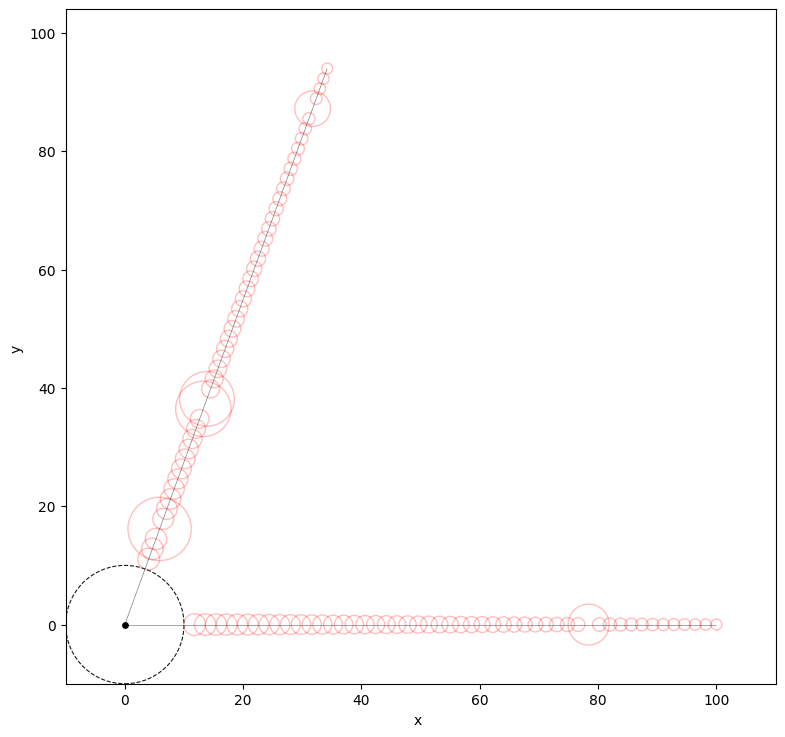

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sk.plot.projection(ax=ax, skel=skel, plane='xy')
ax.set_aspect('equal', 'box')
ax.set_xlim(skel.nodes[:, 0].min() - 10, skel.nodes[:, 0].max() + 10)
ax.set_ylim(skel.nodes[:, 1].min() - 10, skel.nodes[:, 1].max() + 10)
plt.show()

In [6]:
# --- compute degrees to detect terminal nodes ---
degrees = Counter()
for u, v in skel.edges:
    degrees[u] += 1
    degrees[v] += 1

parts = []

# --- soma sphere (still included) ---
soma_pos = skel.nodes[0]
soma_radius = float(skel.radii['mean'][0])
soma_sphere = trimesh.creation.icosphere(subdivisions=3, radius=soma_radius)
soma_sphere.apply_translation(soma_pos)
parts.append(soma_sphere)

# --- frustum (tapered cylinder) generation ---
for u, v in skel.edges:
    p0, p1 = skel.nodes[u], skel.nodes[v]
    r0, r1 = float(skel.radii['mean'][u]), float(skel.radii['mean'][v])

    direction = p1 - p0
    height = np.linalg.norm(direction)
    if height < 1e-8:
        continue

    direction_norm = direction / height
    n_segments = 16
    angles = np.linspace(0, 2 * np.pi, n_segments, endpoint=False)
    circle_2d = np.column_stack([np.cos(angles), np.sin(angles), np.zeros(n_segments)])

    bottom_verts = circle_2d * r0
    top_verts = circle_2d * r1
    top_verts[:, 2] = height
    vertices = np.vstack([bottom_verts, top_verts])

    faces = []
    for i in range(n_segments):
        next_i = (i + 1) % n_segments
        faces.append([i, next_i, n_segments + i])
        faces.append([next_i, n_segments + next_i, n_segments + i])

    # --- only add end caps for terminal nodes ---
    if degrees[u] == 1 and r0 > 1e-8:
        bottom_center_idx = len(vertices)
        vertices = np.vstack([vertices, [0, 0, 0]])
        for i in range(n_segments):
            next_i = (i + 1) % n_segments
            faces.append([bottom_center_idx, next_i, i])

    if degrees[v] == 1 and r1 > 1e-8:
        top_center_idx = len(vertices)
        vertices = np.vstack([vertices, [0, 0, height]])
        for i in range(n_segments):
            next_i = (i + 1) % n_segments
            faces.append([top_center_idx, n_segments + i, n_segments + next_i])

    frustum = trimesh.Trimesh(vertices=vertices, faces=faces, process=False)

    # --- orient the frustum to the actual edge direction ---
    z_axis = np.array([0, 0, 1])
    if np.allclose(direction_norm, z_axis):
        rotation = np.eye(4)
    elif np.allclose(direction_norm, -z_axis):
        rotation = np.eye(4)
        rotation[:3, :3] = np.diag([1, -1, -1])
    else:
        v = np.cross(z_axis, direction_norm)
        s = np.linalg.norm(v)
        c = np.dot(z_axis, direction_norm)
        vx = np.array([
            [0, -v[2], v[1]],
            [v[2], 0, -v[0]],
            [-v[1], v[0], 0]
        ])
        rotation = np.eye(4)
        rotation[:3, :3] = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2))

    rotation[:3, 3] = p0
    frustum.apply_transform(rotation)
    parts.append(frustum)

# --- merge all parts into one continuous surface mesh ---
combined = trimesh.util.concatenate(parts)

# Optional: clean small overlaps, remove duplicate faces, unify normals
combined.remove_duplicate_faces()
combined.remove_degenerate_faces()
combined.remove_unreferenced_vertices()
combined.merge_vertices()
combined.rezero()
combined.fix_normals()

# --- export ---
mesh_path = neuron_path.replace(".swc", ".ply")
combined.export(mesh_path)
print(f"Neuron surface mesh saved to: {mesh_path}")


Neuron surface mesh saved to: data/ball_and_stick_neuron_v1.ply


/tmp/ipykernel_3105674/930815867.py:90: DeprecationWarning: `remove_duplicate_faces` is deprecated and will be removed in March 2024: replace with `mesh.update_faces(mesh.unique_faces())`
  combined.remove_duplicate_faces()
/tmp/ipykernel_3105674/930815867.py:91: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  combined.remove_degenerate_faces()


In [7]:
mesh = sk.io.load_mesh(mesh_path)
skel_from_mesh = sk.skeletonize(mesh=mesh, geodesic_shell_count=5000)

In [8]:
sk.post.calibrate_radii(
    skel = skel_from_mesh,
    mesh = mesh,
    min_n_outer = 20,
    min_frac_outer = 0.33,
    min_verts_q_outer = 75.,
    rays_num_outer = 30,
    rays_thresh_outer = 0.5,
    verbose = True,
    aggregate = 'trimlow'
)

[skeliner] calibrate_radii: min_n_verts_bulb=32=16%


100%|██████████| 61/61 [00:00<00:00, 302.10it/s]

[skeliner] calibrate_radii – N=61, n_fallback=6=10%, n_full_centerline=52=85%, n_outer_centerline=3=5%; store='calibrated', base='trim'


In [9]:
np.unique(skel_from_mesh.extra['calibration']['radius_method'], return_counts=True)

(array(['fallback', 'full_centerline', 'outer_centerline'], dtype='<U16'),
 array([ 6, 52,  3]))

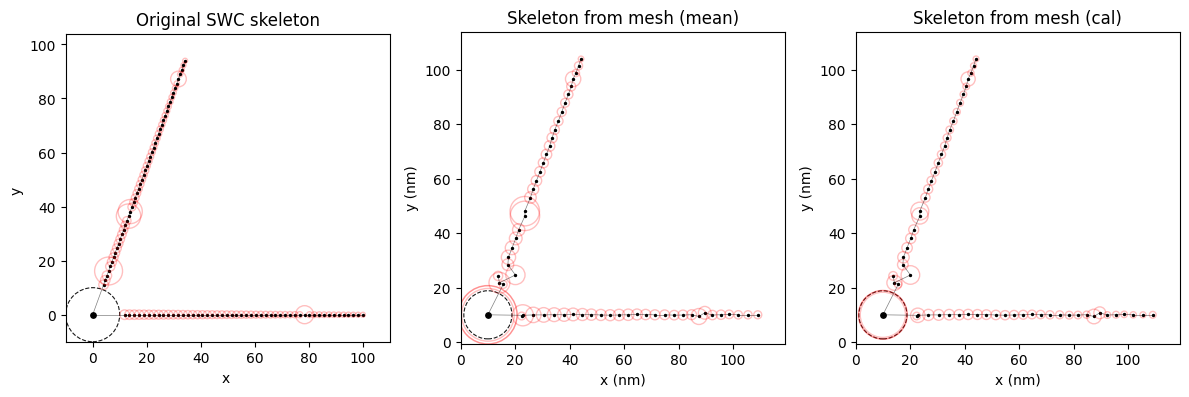

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for i, skel_i in enumerate([skel, skel_from_mesh, skel_from_mesh]):
    ax = axs[i]
    sk.plot.projection(ax=ax, skel=skel_i, plane='xy',
                       radius_metric='mean' if i < 2 else 'calibrated')
    ax.scatter(skel_i.nodes[:, 0], skel_i.nodes[:, 1], c='k', s=2)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(skel_i.nodes[:, 0].min() - 10, skel_i.nodes[:, 0].max() + 10)
    ax.set_ylim(skel_i.nodes[:, 1].min() - 10, skel_i.nodes[:, 1].max() + 10)

axs[0].set_title("Original SWC skeleton")
axs[1].set_title("Skeleton from mesh (mean)")
axs[2].set_title("Skeleton from mesh (cal)")

plt.show()

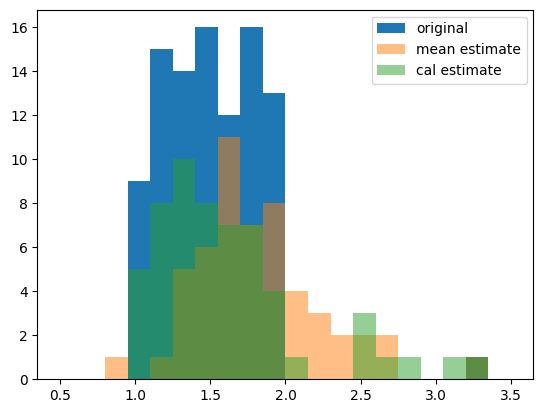

In [11]:
bins = np.linspace(0.5, 3.5, 21)
plt.hist(skel.radii['mean'], bins=bins, label='original')
plt.hist(skel_from_mesh.radii['mean'], alpha=0.5, bins=bins, label='mean estimate')
plt.hist(skel_from_mesh.radii['calibrated'], alpha=0.5, bins=bins, label='cal estimate')
plt.legend()
plt.show()